In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

from shapely import LineString
from pathlib import Path

In [3]:
import pyroll.core as pr
import pyroll.pillar_model
import pyroll.neutral_point_estimator
import pyroll.sparling_spreading
import pyroll.hensel_force_torque
import pyroll.freiberg_flow_stress
import pyroll.ring_model_thermal

In [3]:
from in_profile import create_in_profile_from_surface_temperature
from rolling_sequence import roughing_sequence, intermediate_sequence, finishing_sequence

In [4]:
pyroll.pillar_model.Config.PILLAR_COUNT = 30
pyroll.neutral_point_estimator.Config.ESTIMATOR = "EQUAL"
ROLL_SURFACE_TEMPERATURE = 50 + 273.15
DISK_ELEMENT_COUNT = 30

In [5]:
@pr.CoolingPipe.DiskElement.heat_transfer_coefficient
def heat_transfer_coefficient_model_moreales(self: pr.CoolingPipe.DiskElement):
    mean_surface_temperature = (self.in_profile.surface_temperature - self.out_profile.surface_temperature) / 2

    if mean_surface_temperature <= 650 + 273.15:
        htc = 12.77 * np.exp(-0.00402 * mean_surface_temperature) * self.cooling_pipe.coolant_velocity ** 0.64
    else:
        w_coefficient = self.cooling_pipe.coolant_volume_flux * 1000 / self.cooling_pipe.coolant_flow_cross_section
        htc = 14.06 * w_coefficient ** 0.63 / (mean_surface_temperature - self.cooling_pipe.coolant_temperature)

    return htc * 1000

In [6]:
in_profile = create_in_profile_from_surface_temperature(1100 + 273.15)
in_profile.ring_temperatures = in_profile.ring_temperatures

In [7]:
roughing_train = roughing_sequence(
    roll_surface_temperature=ROLL_SURFACE_TEMPERATURE,
    disk_element_count=DISK_ELEMENT_COUNT
)

intermediate_train = intermediate_sequence(
    roll_surface_temperature=ROLL_SURFACE_TEMPERATURE,
    disk_element_count=DISK_ELEMENT_COUNT
)

finishing_train = finishing_sequence(
    roll_surface_temperature=ROLL_SURFACE_TEMPERATURE,
    disk_element_count=DISK_ELEMENT_COUNT
)


In [8]:
rolling_train = pr.PassSequence([
    roughing_train,
    intermediate_train,
    finishing_train
])

In [9]:
rolling_train.flatten()

In [10]:
rolling_train.solve(in_profile)

Solution iteration of TwoRollPass '3' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '7' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '8' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '14' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '27' exceeded the maximum iteration count of 100. Continuing anyway.


Profile(
    classifiers={'false_round', 'generic_elongation', 'round', 'symmetric'},
    core_temperature=np.float64(1413.864296380053),
    cross_section=Polygon(
        area=5.8943467361174393e-05,
        height=0.008650000000000007,
        perimeter=0.027258476232334846,
        width=0.008764599219576934,
        ),
    flow_stress=100000000.0,
    length=0.0,
    material=['BST500', 'steel'],
    ring_temperatures=array([1413.86429638, 1407.96352408, 1390.32134586, 1361.08532615,
           1320.21448874, 1266.91915722, 1199.19095572, 1115.00725486,
           1017.54772062,  923.37172913,  863.003913  ]),
    strain=np.float64(0.46928979759424105),
    surface_temperature=np.float64(863.0039130007317),
    t=np.float64(36.84595596207732),
    temperature=np.float64(1091.4110139796092),
    width=np.float64(0.008764599219576934),
    )

/home/christoph/PycharmProjects/phd-thesis-fitting-wear-coefficient/.venv/lib/python3.13/site-packages/pyroll/report/unit_display/plots.py:169: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

/home/christoph/PycharmProjects/phd-thesis-fitting-wear-coefficient/.venv/lib/python3.13/site-packages/pyroll/pillar_model/report.py:81: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

/home/christoph/PycharmProjects/phd-thesis-fitting-wear-coefficient/.venv/lib/python3.13/

45414265

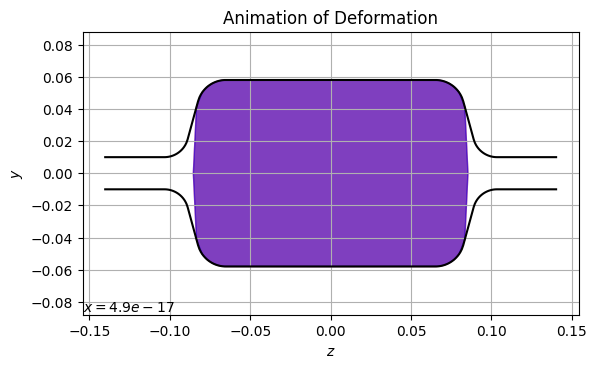

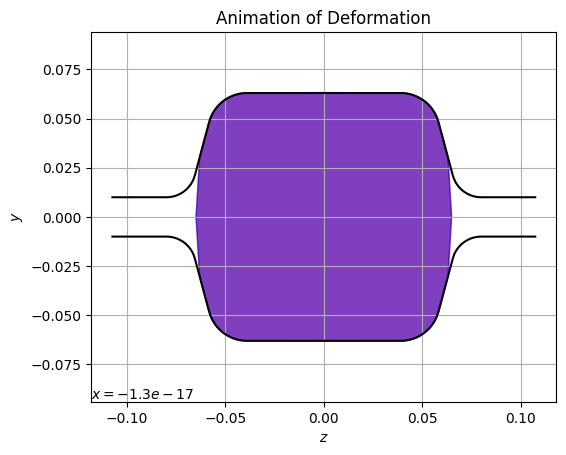

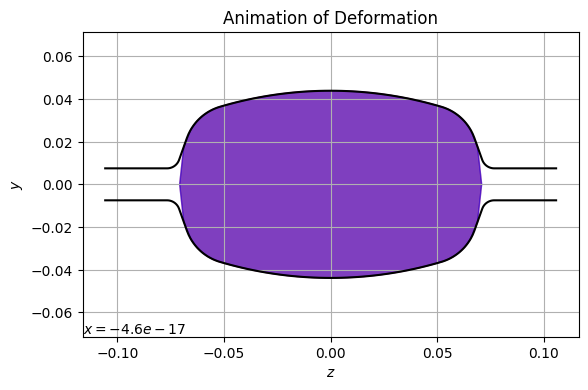

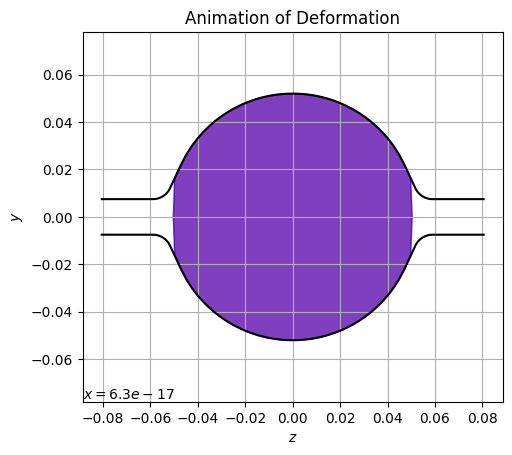

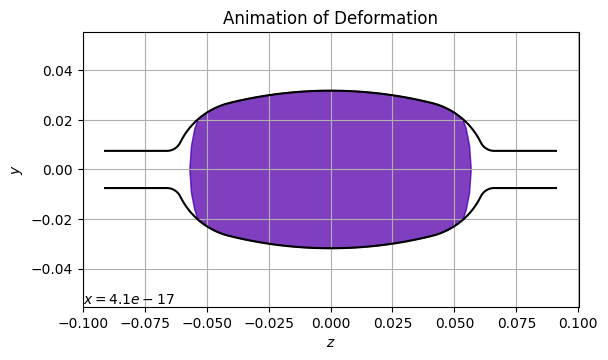

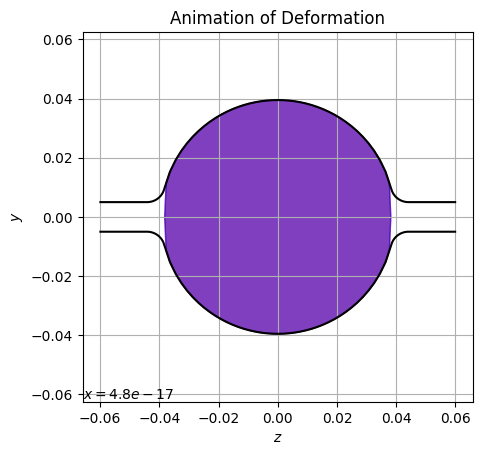

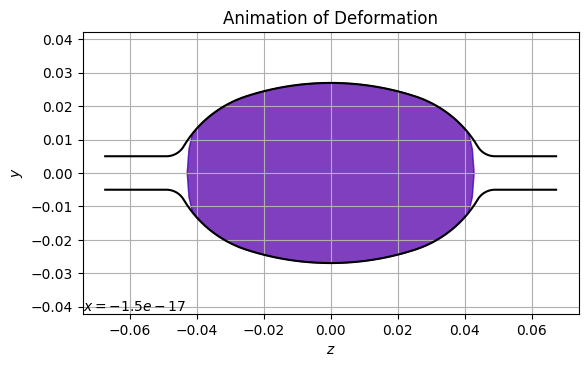

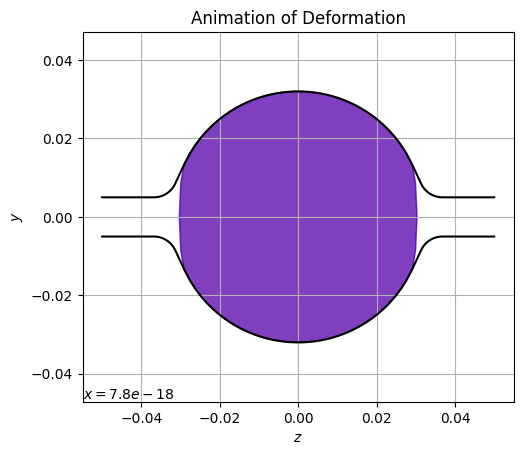

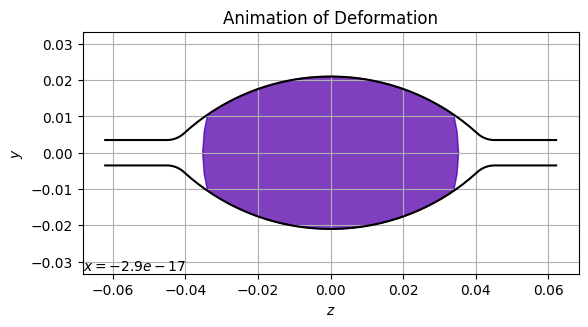

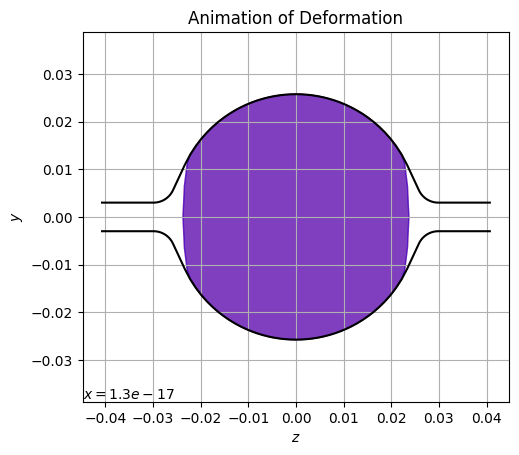

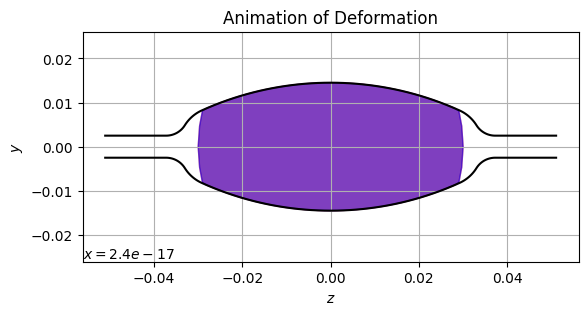

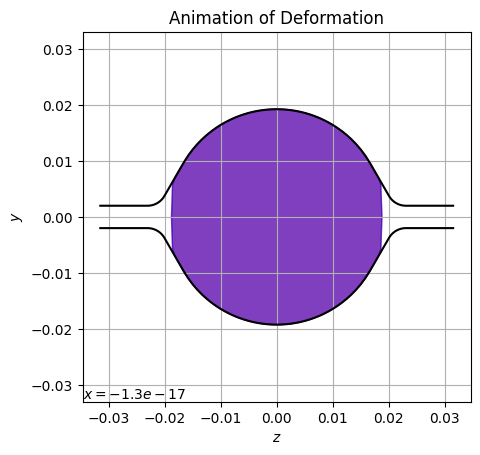

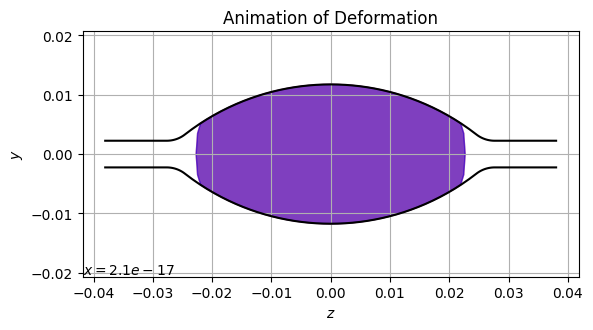

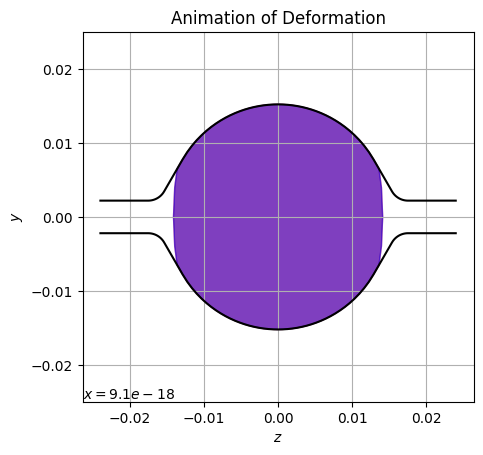

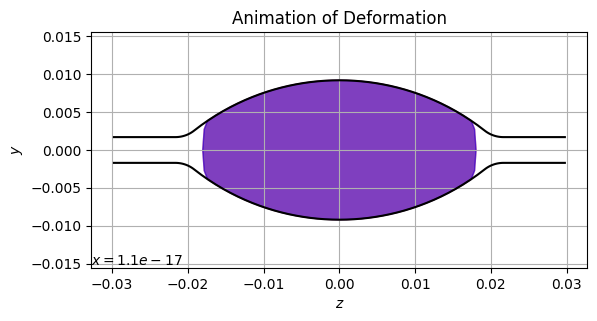

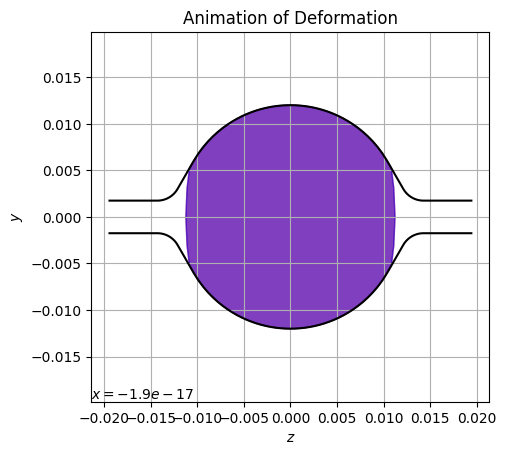

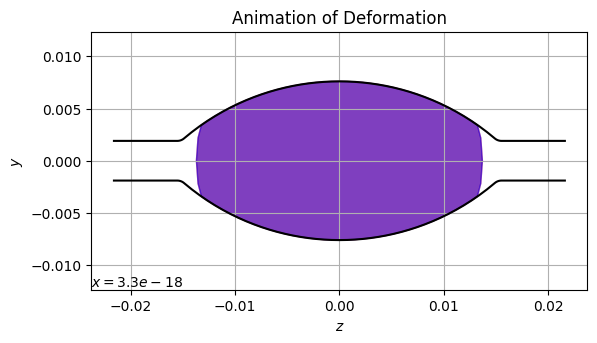

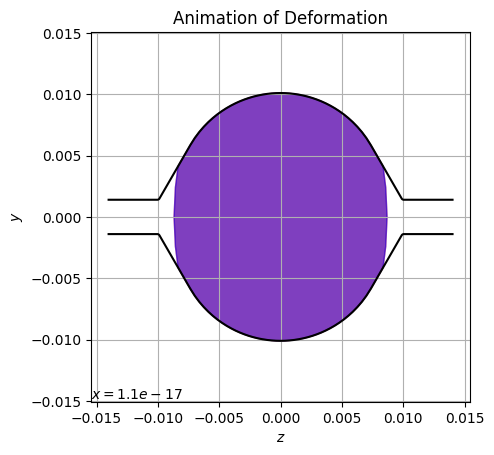

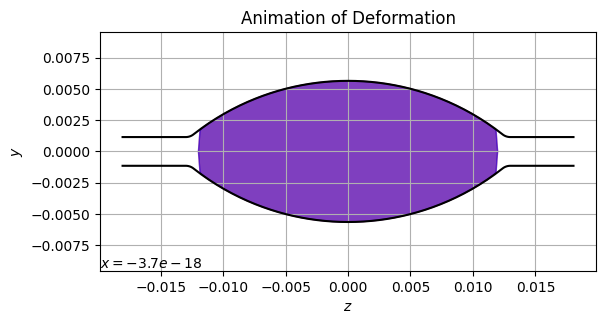

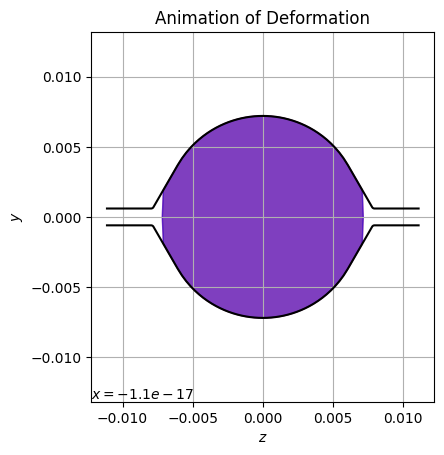

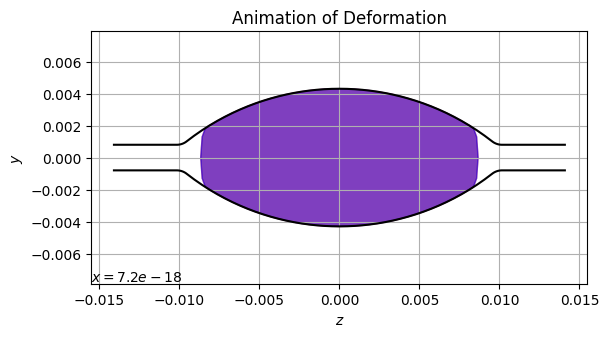

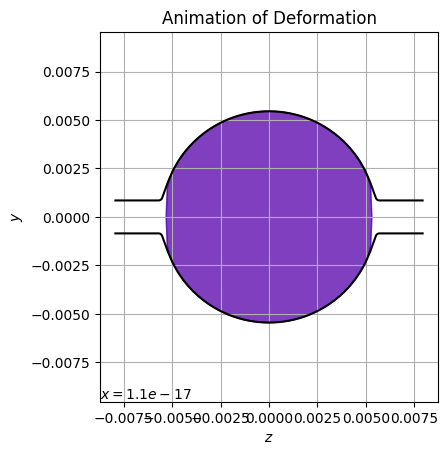

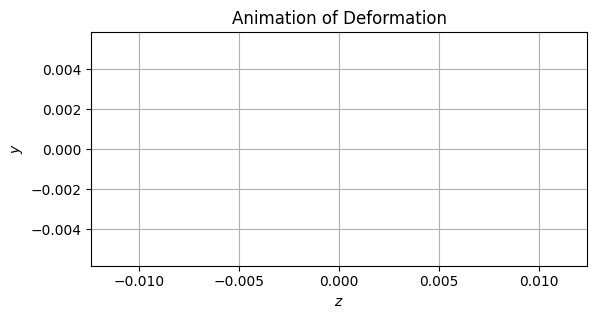

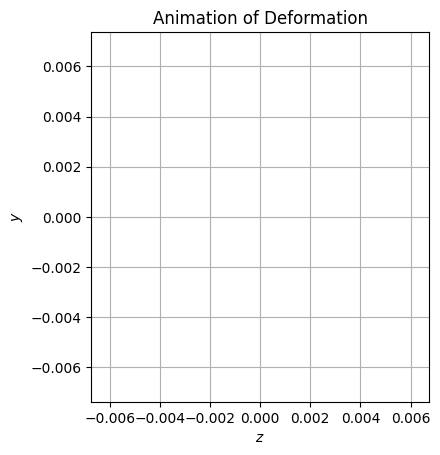

In [11]:

from pyroll.report import report

roughing_train_report = report(rolling_train)
f = Path("report.html")
f.write_text(roughing_train_report, encoding="utf-8")

In [ ]:
def pillar_deformation_resistance(roll_pass: pr.RollPass):
    from pyroll.freiberg_flow_stress import flow_stress
    pillars_flow_stress = flow_stress(roll_pass.out_profile.freiberg_flow_stress_coefficients,
                                      roll_pass.total_pillar_strains,
                                      roll_pass.total_pillar_strain_rates,
                                      roll_pass.out_profile.temperature)
    pillar_deformation_resistance = pillars_flow_stress / roll_pass.rolling_efficiency
    return pillar_deformation_resistance


def pillars_wear_length(roll: pr.RollPass.Roll) -> np.ndarray:
    local_roll_radii = np.concatenate(
        [roll.max_radius - roll.surface_interpolation(0, center)
         for center in roll.roll_pass.in_profile.pillars],
        axis=0).flatten()

    pillars_wear_length = np.zeros_like(roll.roll_pass.in_profile.pillars)

    for de in roll.roll_pass.disk_elements:
        horizontal_roll_velocities = local_roll_radii * roll.rotational_frequency * 2 * np.pi * np.cos(
            de.pillar_longitudinal_angles)
        for i, pillars in enumerate(de.in_profile.pillars):
            if de.pillar_velocities[i] < horizontal_roll_velocities[i] and de.pillars_in_contact[i]:
                pillars_wear_length[i] += de.length

    return pillars_wear_length

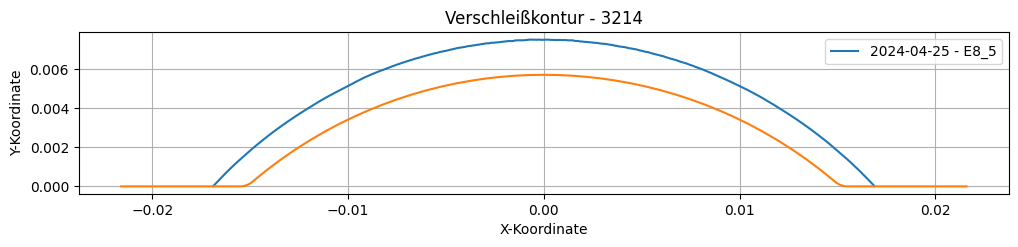

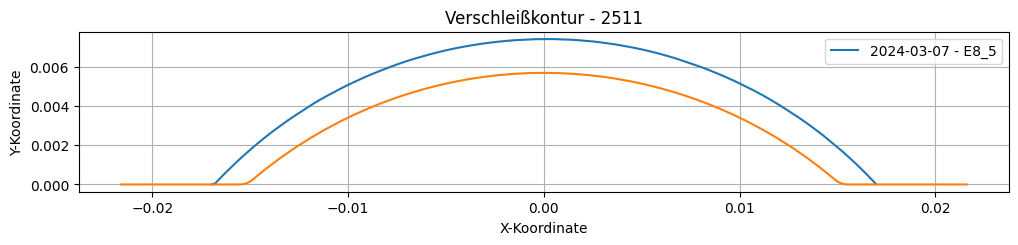

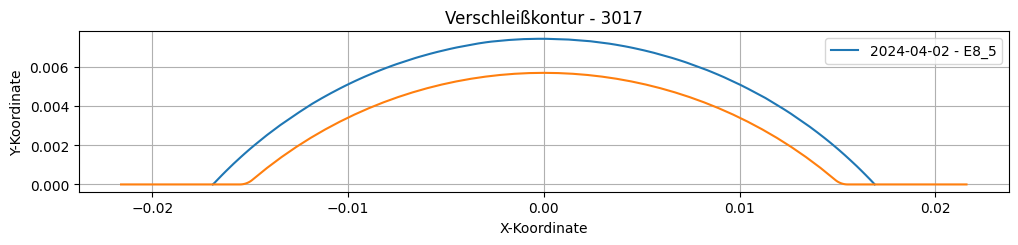

In [14]:
root_dir = Path.cwd()
wear_data_dir = root_dir / "wear_data"

for file in wear_data_dir.iterdir():
    with open(file, "r") as file:
        data = json.load(file)
    ov1_groove: pr.CircularOvalGroove = pr.CircularOvalGroove(
        depth=5.7e-3,
        r1=1e-3,
        r2=23e-3,
    )
    fig, ax = plt.subplots(figsize=(12, 8))

    for entry in data["wear_data"]:
        if entry['groove'] == 'OV1':
            x_values = np.array([point["x"]* 1e-3 for point in entry["wear_contour"]])
            y_values = np.array([point["y"]* 1e-3 for point in entry["wear_contour"]])
            x_values_shifted = x_values - max(x_values) / 2
    ax.plot(x_values_shifted, y_values, label=f"{entry['date']} - {entry['groove']}")
    ax.set_title("Verschleißkontur - " + str(entry["tonnage"]))
    ax.plot(*ov1_groove.contour_line.xy)
    ax.set_xlabel("X-Koordinate")
    ax.set_ylabel("Y-Koordinate")
    ax.set_aspect("equal")
    ax.legend()
    ax.grid(True)

In [ ]:
def solve_total_wear_depths_as_contour_line(sequence: pr.PassSequence, wear_coefficient: float, case):
    vickers_hardness_c15c = 900

    roll_passes = sequence.roll_passes

    tonnages = []
    wear_contours = []
    for roll_pass, tonnage in zip(roll_passes, tonnages):
        pillars_wear_length = pillars_wear_length(roll_pass.roll)
        pillar_deformation_resistance = pillar_deformation_resistance(roll_pass)
        pillar_wear_depths = wear_coefficient * pillar_deformation_resistance * pillars_wear_length / (
                3 * vickers_hardness_c15c)
        total_pillar_wear_depths = pillar_wear_depths * tonnage / roll_pass.in_profile.weight
        wear_depths_with_groove_contour = roll_pass.roll.groove.local_depth(
            roll_pass.out_profile.pillars) + total_pillar_wear_depths
        right_side = list(zip(roll_pass.out_profile.pillars, wear_depths_with_groove_contour))
        left_side = list(zip(-roll_pass.out_profile.pillars[::-1], wear_depths_with_groove_contour[::-1]))
        combined_contour_list = left_side + right_side
        wear_contours.append(LineString(combined_contour_list))



In [ ]:
pillar_deformation_resistances = []
pillars_wear_lengths = []

for roll_pass in rolling_train.roll_passes:
    pillar_deformation_resistances.append(pillar_deformation_resistance(roll_pass))
    pillars_wear_lengths.append(pillars_wear_length(roll_pass.roll))
